In [5]:
%load_ext autoreload
%autoreload 2

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import timeit

from rpy2.robjects.packages import importr
from rpy2.robjects import numpy2ri, default_converter
from rpy2.robjects.conversion import localconverter

glstudy = importr("glstudy")
np_cv_rules = default_converter + numpy2ri.converter

In [67]:
def check_acc(beta, L, v, l1, l2):
    return beta - (v /(L + l2 + l1 / np.sqrt(np.sum(beta**2))))

In [68]:
def bench(ps, configs):
    index_names = ['Newton', 'ISTA', 'FISTA', 'FISTA-ADA']

    n_ps = len(ps)
    n_algs = len(index_names)
    times = np.zeros((n_algs, n_ps))
    iters = np.zeros((n_algs, n_ps))
    accs = np.zeros((n_algs, n_ps))
    
    number = configs['n_times']
    seed = configs['seed']
    max_eval = configs['max_eval']
    l1 = configs['l1']
    l2 = configs['l2']
    newton_tol = configs['newton_tol']
    fista_tol = configs['fista_tol']
    max_iters = configs['max_iters']

    for i, p in enumerate(ps):
        np.random.seed((seed + 100*i) % 1000007)
        
        # generate data
        L_zero_prop = configs['L_zero_prop']
        L_small_prop = configs['L_small_prop']
        L = np.concatenate(
            [np.zeros(int(p * L_zero_prop)),
             np.random.uniform(1e-14, 1e-8, int(p * L_small_prop))]
        )
        L = np.concatenate(
            [L, np.random.uniform(1e-4, max_eval, p - len(L))]
        )
        v = np.random.normal(0, 1, size=(p,)) * np.sqrt(L)

        with localconverter(np_cv_rules):
            # call for outputs
            newton_out = glstudy.newton_solver(L, v, l1, l2, newton_tol, max_iters) 
            ista_out = glstudy.ista_solver(L, v, l1, l2, fista_tol, max_iters)
            fista_out = glstudy.fista_solver(L, v, l1, l2, fista_tol, max_iters)
            fista_ada_out = glstudy.fista_adares_solver(L, v, l1, l2, fista_tol, max_iters)

            # benchmark
            curr_number = 20 if p <= 50 else number
            newton_time = timeit.repeat(
                lambda: glstudy.newton_solver(L, v, l1, l2, newton_tol, max_iters), 
                repeat=1, 
                number=curr_number,
            )[0] / curr_number
            ista_time = timeit.repeat(
                lambda: glstudy.ista_solver(L, v, l1, l2, fista_tol, max_iters), 
                repeat=1, 
                number=curr_number,
            )[0] / curr_number
            fista_time = timeit.repeat(
                lambda: glstudy.fista_solver(L, v, l1, l2, fista_tol, max_iters), 
                repeat=1, 
                number=curr_number,
            )[0] / curr_number
            fista_ada_time = timeit.repeat(
                lambda: glstudy.fista_adares_solver(L, v, l1, l2, fista_tol, max_iters), 
                repeat=1, 
                number=curr_number,
            )[0] / curr_number
        
            # save output
            times[:, i] = [newton_time, ista_time, fista_time, fista_ada_time]
            iters[:, i] = [
                newton_out['iters'][0],
                ista_out['iters'][0],
                fista_out['iters'][0],
                fista_ada_out['iters'][0],
            ]
            accs[:, i] =[
                np.max(np.abs(check_acc(newton_out['beta'], L, v, l1, l2))),
                np.max(np.abs(check_acc(ista_out['beta'], L, v, l1, l2))),
                np.max(np.abs(check_acc(fista_out['beta'], L, v, l1, l2))),
                np.max(np.abs(check_acc(fista_ada_out['beta'], L, v, l1, l2))),
            ]

    return ps, configs, index_names, times, iters, accs


def vbench(configs):
    return [bench(**config) for config in configs]


In [69]:
def bench_assess(bench_out, filename):
    ps, _, index_names, times, iters, accs = bench_out

    types = [iters, times, accs]
    type_names = ["Iterations", "Time", "Accuracy"]
    ylabels = ["Iterations", "Time (s)", "$\max_i |\hat{\\beta}_i - \\beta^{\star}_i |$"]

    markers = ['.', 'v', 'x', '*']
    linestyles = ['-', '--', '-.', ':']

    _, axd = plt.subplot_mosaic(
        [["upper left", "right"],
        ["bottom left", "right"]],
        figsize=(8, 6),
    )
    for j, k in enumerate(axd):
        ax = axd[k]
        vals = types[j]
        for i, vals_alg in enumerate(vals):
            ax.plot(ps, vals_alg, marker=markers[i], label=index_names[i], linestyle=linestyles[i])
        ax.legend()
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title(f"{type_names[j]} Comparison")
        ax.set_xlabel("Number of features")
        ax.set_ylabel(ylabels[j])

    plt.tight_layout()
    plt.savefig(f"figures/pgd_newton_{filename}.pdf", bbox_inches='tight')
    plt.show()

    return bench_out

In [70]:
ps = np.array([10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 750, 1000, 2000, 5000])

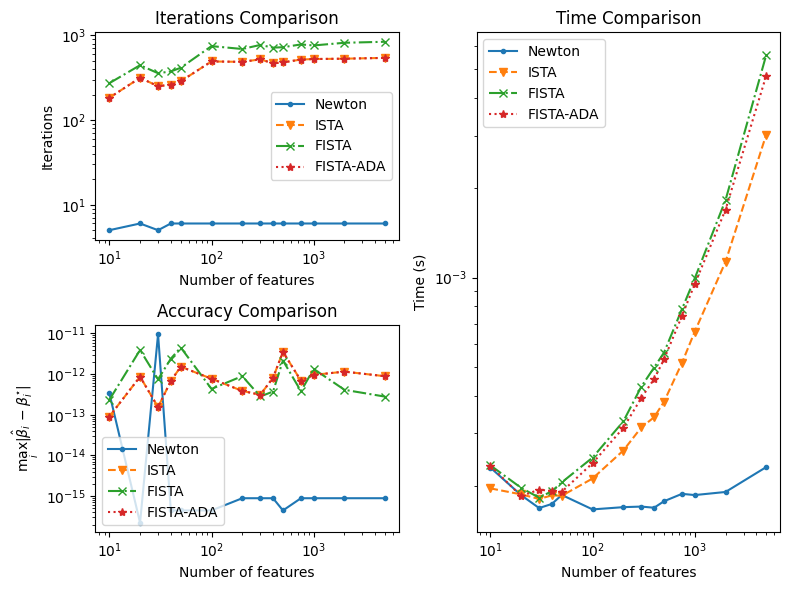

In [71]:
configs = {
    'n_times': 100,
    'seed': 69, 
    'max_eval': 2, 
    'l1': 1e-1, 
    "l2": 1e-1, 
    "newton_tol": 1e-10, 
    "fista_tol": 1e-13, 
    "max_iters": int(1e4),
    'L_zero_prop': 0.0,
    'L_small_prop': 0.0,
}
bench_out = bench_assess(bench(ps, configs), filename='pd')

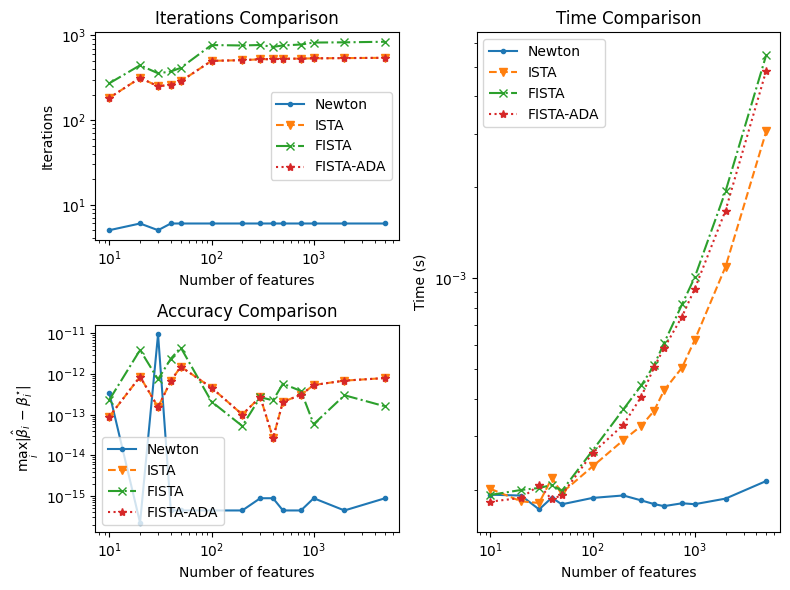

In [72]:
configs = {
    'n_times': 100,
    'seed': 69, 
    'max_eval': 2, 
    'l1': 1e-1, 
    "l2": 1e-1, 
    "newton_tol": 1e-10, 
    "fista_tol": 1e-13, 
    "max_iters": int(1e4),
    'L_zero_prop': 0.0,
    'L_small_prop': 0.01,
}
bench_out = bench_assess(bench(ps, configs), filename='almost_psd')

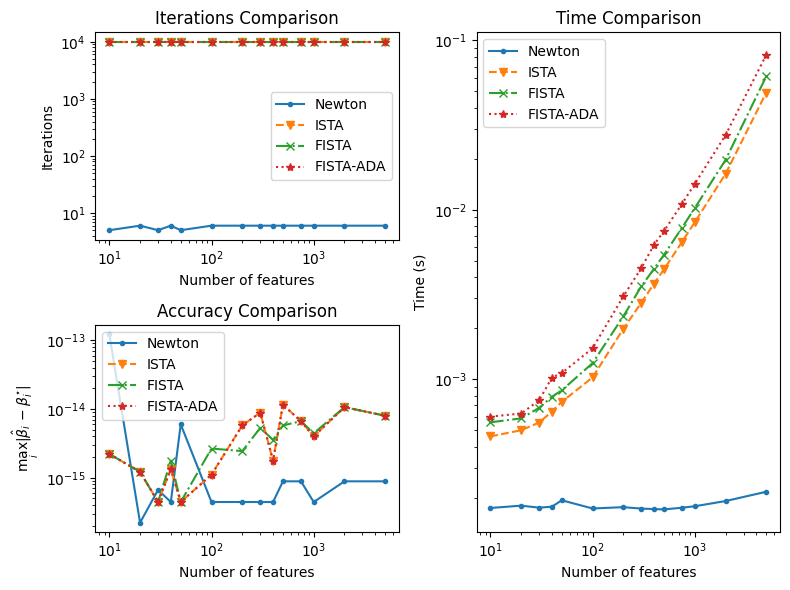

In [73]:
configs = {
    'n_times': 100,
    'seed': 69, 
    'max_eval': 2, 
    'l1': 1e-1, 
    "l2": 1e-1, 
    "newton_tol": 1e-10, 
    "fista_tol": 1e-13, 
    "max_iters": int(1e4),
    'L_zero_prop': 0.1,
    'L_small_prop': 0.2,
}
bench_out = bench_assess(bench(ps, configs), filename='very_psd')